# Fixed Price Compare

This notebook generates barcharts comparing the electricity cost for systems in power only mode at fixed natural gas and electricity price points.

## Generate Surrogates and Boilerplate

In [1]:
from util.surrogate import SurrogateProcessModels
from util.data import get_model_data
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
surrogate = SurrogateProcessModels()
surrogate.generate_surrogate_models()

In [3]:
solver_obj = pyo.SolverFactory("ipopt")

In [4]:
plot_dir = "../fixed_price_plots"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Power Only Mode Bar Chart

In [5]:
model0 = surrogate.single_point_model("model0", "power_only", el_price=71.70, ng_price=4.42)
model1 = surrogate.single_point_model("model1", "power_only", el_price=71.70, ng_price=4.42)
model3 = surrogate.single_point_model("model3", "power_only", el_price=71.70, ng_price=4.42)
model4 = surrogate.single_point_model("model4", "power_only", el_price=71.70, ng_price=4.42)
model5 = surrogate.single_point_model("model5", "power_only", el_price=71.70, ng_price=4.42)

all_models = [model0, model1, model3, model4, model5]

for m in all_models:
    m.net_power.fix(m.net_power.ub)

Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (200.0, 650.0).
Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (200.0, 650.0).
Setting bound of net_power to (219.07692307692307, 712.0).


In [6]:
cases = ["NGCC", "SOFC", "NGCC+SOEC", "rSOC", "SOFC+SOEC"]
capital = {}
fixed_om = {}
fuel = {}
other = {}
ng_prices = [4.42, 8]

for ng_price in ng_prices:
    for m in all_models:
        m.ng_price.fix(ng_price)
        res = solver_obj.solve(m)

    model_data = get_model_data()
        
    capital[ng_price] = np.array([
        model_data["model0"]["fixed_cap_hourly"]/pyo.value(model0.net_power), 
        model_data["model1"]["fixed_cap_hourly"]/pyo.value(model1.net_power), 
        model_data["model3"]["fixed_cap_hourly"]/pyo.value(model3.net_power), 
        model_data["model4"]["fixed_cap_hourly"]/pyo.value(model4.net_power), 
        model_data["model5"]["fixed_cap_hourly"]/pyo.value(model5.net_power), 
    ])
    fixed_om[ng_price] = np.array([
        model_data["model0"]["fixed_om_hourly"]/pyo.value(model0.net_power), 
        model_data["model1"]["fixed_om_hourly"]/pyo.value(model1.net_power), 
        model_data["model3"]["fixed_om_hourly"]/pyo.value(model3.net_power), 
        model_data["model4"]["fixed_om_hourly"]/pyo.value(model4.net_power), 
        model_data["model5"]["fixed_om_hourly"]/pyo.value(model5.net_power), 
    ])
    fuel[ng_price] = np.array([
        pyo.value((model0.ng_price/4.42)*model0.fuel_cost)/pyo.value(model0.net_power),
        pyo.value((model1.ng_price/4.42)*model1.fuel_cost)/pyo.value(model1.net_power),
        pyo.value((model3.ng_price/4.42)*model3.fuel_cost)/pyo.value(model3.net_power),
        pyo.value((model4.ng_price/4.42)*model4.fuel_cost)/pyo.value(model4.net_power),
        pyo.value((model5.ng_price/4.42)*model5.fuel_cost)/pyo.value(model5.net_power),
    ])
    other[ng_price] = np.array([
        pyo.value(model0.other_cost)/pyo.value(model0.net_power),
        pyo.value(model1.other_cost)/pyo.value(model1.net_power),
        pyo.value(model3.other_cost)/pyo.value(model3.net_power),
        pyo.value(model4.other_cost)/pyo.value(model4.net_power),
        pyo.value(model5.other_cost)/pyo.value(model5.net_power),
    ])

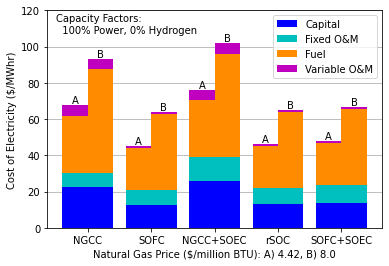

In [7]:
w = 0.4
plot_file = os.path.join(plot_dir, "bar_power_only.png")
fig, ax = plt.subplots()
plt.grid(axis='y', zorder=0)
idx = np.arange(len(cases))

for i, ng_price in enumerate(ng_prices):
    if i == 0:
        l = "A"
    else:
        l = "B"
    b1 = plt.bar(
        idx - 0.2 + i*w, 
        capital[ng_price], 
        width=w, 
        label="Capital", 
        zorder=3, 
        color='blue'
    )
    b2 = plt.bar(
        idx - 0.2 + i*w, 
        fixed_om[ng_price], 
        width=w, 
        label="Fixed O&M", 
        bottom=capital[ng_price], 
        zorder=3, 
        color='c'
    )
    plt.bar(
        idx - 0.2 + i*w, 
        fuel[ng_price], 
        width=w, 
        label="Fuel", 
        bottom=capital[ng_price]+fixed_om[ng_price], 
        zorder=3, 
        color='darkorange'
    )
    b = plt.bar(
        idx - 0.2 + i*w, 
        other[ng_price], 
        width=w, 
        label="Variable O&M", 
        bottom=capital[ng_price]+fixed_om[ng_price]+fuel[ng_price], 
        zorder=3, 
        color='m'
    )
    plt.bar_label(b, labels=[l]*len(cases))
plt.xlabel("Natural Gas Price (\$/million BTU): A) 4.42, B) 8.0")
plt.text(-0.5, 107.5, "Capacity Factors:\n  100% Power, 0% Hydrogen")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=1)
plt.xticks(idx, labels=cases)
plt.ylim(0, 120)
plt.ylabel("Cost of Electricity ($/MWhr)")
plt.savefig(plot_file, dpi=160, bbox_inches="tight")
plt.show()

## Hydrogren Price Bar Chart

This chart compares the optimal cost of hydrogen from system that can produce hydrogen.

In [8]:
model3 = surrogate.single_point_model("model3", "hydrogen", el_price=71.70, ng_price=4.42)
model4 = surrogate.single_point_model("model4", "hydrogen_only", el_price=71.70, ng_price=4.42)
model5 = surrogate.single_point_model("model5", "hydrogen", el_price=71.70, ng_price=4.42)
model6 = surrogate.single_point_model("model6", "hydrogen_only", el_price=71.70, ng_price=4.42)

all_models = [model3, model4, model5, model6]

for m in all_models:
    m.h_prod.fix(m.h_prod.ub)

Setting bound of net_power to (-78.4122027155605, 508.793449280259).
Setting bound of h_prod to (1.00004960563519, 4.7502356267672).
Setting bound of h_prod to (1.75, 5.0).
Setting bound of net_power to (-378.391, 546.7495).
Setting bound of h_prod to (1.0, 5.0).
Setting bound of h_prod to (1.0, 5.0).


In [9]:
cases = ["NGCC+SOEC", "rSOC", "SOFC+SOEC", "SOEC"]

capital = {}
fixed_om = {}
fuel = {}
elec = {}
other = {}

ng_prices = [4.42, 8]
el_prices = [30, 71.70, 100]

for ng_price in ng_prices:
    for el_price in el_prices:
        for m in all_models:
            m.ng_price.fix(ng_price)
            m.el_price.fix(el_price)
            res = solver_obj.solve(m)
            
        capital[(ng_price, el_price)] = np.array([
            model_data["model3"]["fixed_cap_hourly"]/pyo.value(model3.h_prod*3600), 
            model_data["model4"]["fixed_cap_hourly"]/pyo.value(model4.h_prod*3600), 
            model_data["model5"]["fixed_cap_hourly"]/pyo.value(model5.h_prod*3600), 
            model_data["model6"]["fixed_cap_hourly"]/pyo.value(model6.h_prod*3600), 
        ])
        fixed_om[(ng_price, el_price)] = np.array([
            model_data["model3"]["fixed_om_hourly"]/pyo.value(model3.h_prod*3600), 
            model_data["model4"]["fixed_om_hourly"]/pyo.value(model4.h_prod*3600), 
            model_data["model5"]["fixed_om_hourly"]/pyo.value(model5.h_prod*3600), 
            model_data["model6"]["fixed_om_hourly"]/pyo.value(model6.h_prod*3600), 
        ])
        fuel[(ng_price, el_price)] = np.array([
            pyo.value((model3.ng_price/4.42)*model3.fuel_cost)/pyo.value(model3.h_prod*3600),
            pyo.value((model4.ng_price/4.42)*model4.fuel_cost)/pyo.value(model4.h_prod*3600),
            pyo.value((model5.ng_price/4.42)*model5.fuel_cost)/pyo.value(model5.h_prod*3600),
            pyo.value((model6.ng_price/4.42)*model6.fuel_cost)/pyo.value(model6.h_prod*3600),
        ])
        elec[(ng_price, el_price)] = np.array([
            pyo.value(-model3.el_price*model3.net_power)/pyo.value(model3.h_prod*3600),
            pyo.value((model4.el_price/30)*model4.electricity_cost)/pyo.value(model4.h_prod*3600),
            pyo.value(-model5.el_price*model5.net_power)/pyo.value(model5.h_prod*3600),
            pyo.value((model6.el_price/30)*model6.electricity_cost)/pyo.value(model6.h_prod*3600),
        ])
        other[(ng_price, el_price)] = np.array([
            pyo.value(model3.other_cost)/pyo.value(model3.h_prod*3600),
            pyo.value(model4.other_cost)/pyo.value(model4.h_prod*3600),
            pyo.value(model5.other_cost)/pyo.value(model5.h_prod*3600),
            pyo.value(model6.other_cost)/pyo.value(model6.h_prod*3600),
        ])

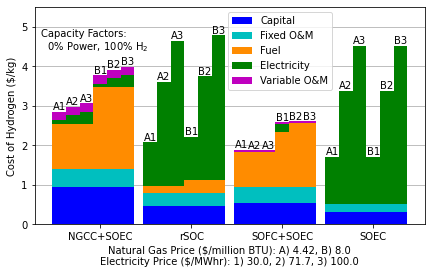

In [10]:
plot_file = os.path.join(plot_dir, "bar_hydrogen.png")
w = 0.15
fig, ax = plt.subplots()
fig.set_figwidth(7)
plt.grid(axis='y', zorder=0)
idx = np.arange(len(cases))
ng_price = 4.42
el_price = 30
i = 0
for ng_price in ng_prices:
    for el_price in el_prices:
        plt.bar(
            idx - 3*w + i*w, 
            capital[(ng_price, el_price)], 
            width=w, 
            label="Capital", 
            zorder=3,
            color='b',
        )
        plt.bar(
            idx - 3*w + i*w, 
            fixed_om[(ng_price, el_price)], 
            width=w,label="Fixed O&M", 
            bottom=capital[(ng_price, el_price)], 
            zorder=3,
            color='c',
        )
        plt.bar(
            idx - 3*w + i*w, 
            fuel[(ng_price, el_price)], 
            width=w, 
            label="Fuel", 
            bottom=capital[(ng_price, el_price)]+fixed_om[(ng_price, el_price)], 
            zorder=3,
            color='darkorange',
        )
        plt.bar(
            idx - 3*w + i*w, 
            elec[(ng_price, el_price)], 
            width=w, 
            label="Electricity", 
            bottom=capital[(ng_price, el_price)]+fixed_om[(ng_price, el_price)]+fuel[(ng_price, el_price)], 
            zorder=3,
            color='green'
        )
        b = plt.bar(
            idx - 3*w + i*w, 
            other[(ng_price, el_price)], 
            width=w, 
            label="Variable O&M", 
            bottom=capital[(ng_price, el_price)]+fixed_om[(ng_price, el_price)]+fuel[(ng_price, el_price)]+elec[(ng_price, el_price)], 
            zorder=3,
            color='m',
        )
        plt.bar_label(b, [{0:"A1", 1:"A2", 2:"A3", 3:"B1", 4:"B2", 5:"B3"}[i]]*len(cases))
        i += 1
plt.xlabel("Natural Gas Price (\$/million BTU): A) 4.42, B) 8.0\nElectricity Price (\$/MWhr): 1) 30.0, 2) 71.7, 3) 100.0")
plt.text(-0.65, 4.4, "Capacity Factors: \n  0% Power, 100% H$_2$")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right", bbox_to_anchor=(0.775, 1))
plt.xticks(idx, labels=cases)
plt.ylim(0, 5.5)
plt.ylabel("Cost of Hydrogen ($/kg)")
plt.savefig(plot_file, dpi=160, bbox_inches="tight")
plt.show()